# Analysis of data
Time to start analysing! First need to check quality of data for missing values and other quirks

## Useful imports

In [1]:
#Import useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
from collections import Counter

# Importing data and formatting it properly
Data from csv won't have correct datatypes as in the python program that generated the file so need to check the datatypes and fix the abberant ones

In [2]:
data_table = pd.read_csv("complete todo final.csv")
#drop unneeded cols
data_table = data_table.drop(["Unnamed: 0","day"],axis=1)
data_table.head(5)

,date,ordinal_date,dayofweek,start_time,end_time,time_taken,activity,activity status,planned
0,2018-03-01,0,Thursday,09:00:00,NaN,NaN,9: Take histo down to Nick in the store on lvl 1,done,True
1,2018-03-01,0,Thursday,10:30:00,13:30:00,180.0,10:30-1:30: Animal facilities induction,done,True
2,2018-03-01,0,Thursday,14:00:00,15:00:00,60.0,2-3: Microbiome meeting,done,True
3,2018-03-01,0,Thursday,14:30:00,17:00:00,150.0,2:30-5: KB22 Collagen Analysis,done,True
4,2018-03-02,1,Friday,09:00:00,16:00:00,420.0,9-4: BALF processing for endpoint (Alex),done,True


In [3]:
for col_name in data_table.columns:
    print(col_name, '\t\t', type(data_table[col_name][0]))

date 		 <class 'str'>
ordinal_date 		 <class 'numpy.int64'>
dayofweek 		 <class 'str'>
start_time 		 <class 'str'>
end_time 		 <class 'float'>
time_taken 		 <class 'numpy.float64'>
activity 		 <class 'str'>
activity status 		 <class 'str'>
planned 		 <class 'numpy.bool_'>


So date is not the right class. The rest are fine.  
To fix `date` I can use `pd.to_datetime()` which has fairly clean syntax.

In [4]:
data_table['date'] = pd.to_datetime(data_table['date'])

# Analysis of missing data
Quick analysis of missing data in the todo dataset.  
Should only be missing entries in start_time and end_time where there are entries without times.  
Also expecting some start times with no corresponding ent times or time_taken entries.

In [5]:
import missingno as msno

First, check to see what is missing data

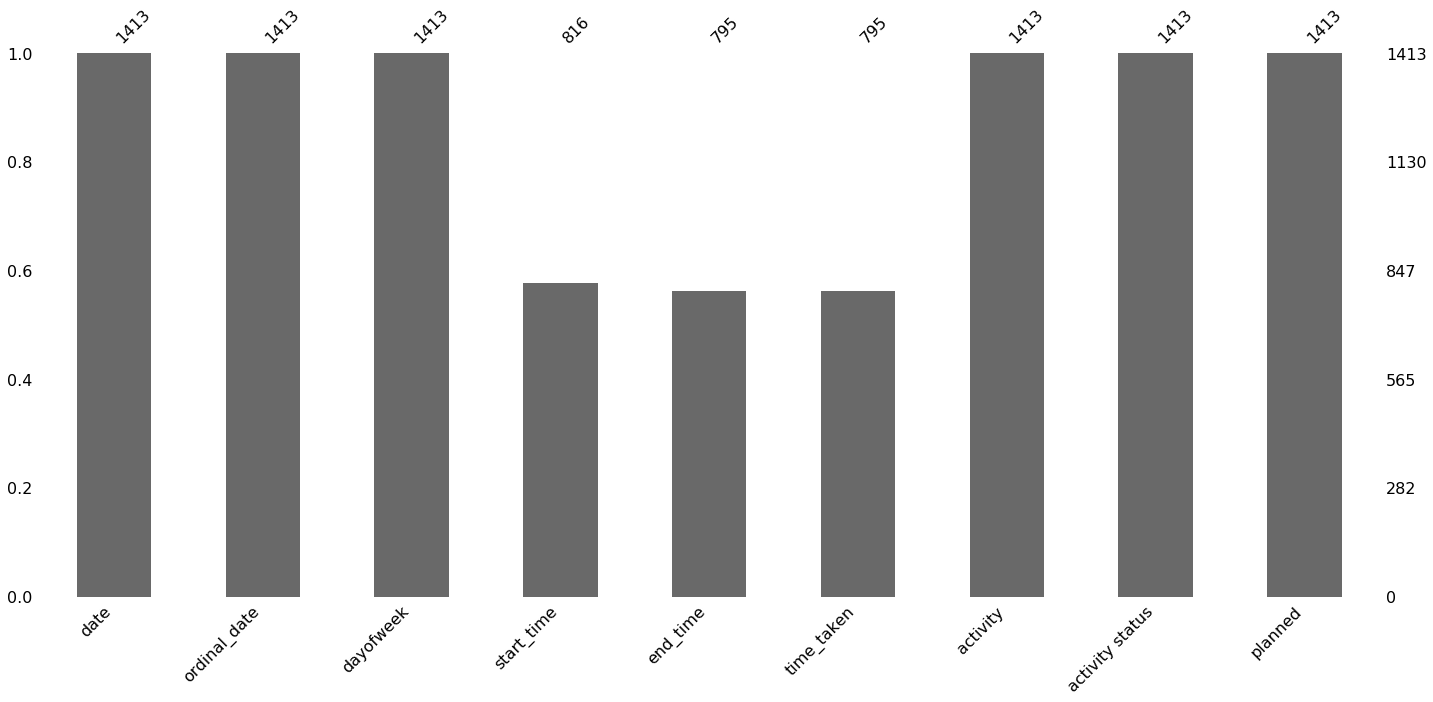

In [6]:
msno.bar(data_table)

Check for missing entries using a for loop. Looks like only missing entries where there should be.

In [155]:
results_dict = {}
for col_name in data_table.columns:
    results_dict[col_name] = sum(data_table[col_name].isnull())
pd.Series(results_dict)

date                 0
ordinal_date         0
dayofweek            0
start_time         597
end_time           618
time_taken         618
activity             0
activity status      0
planned              0
dtype: int64

Check pattern of missing data for start and end times visually

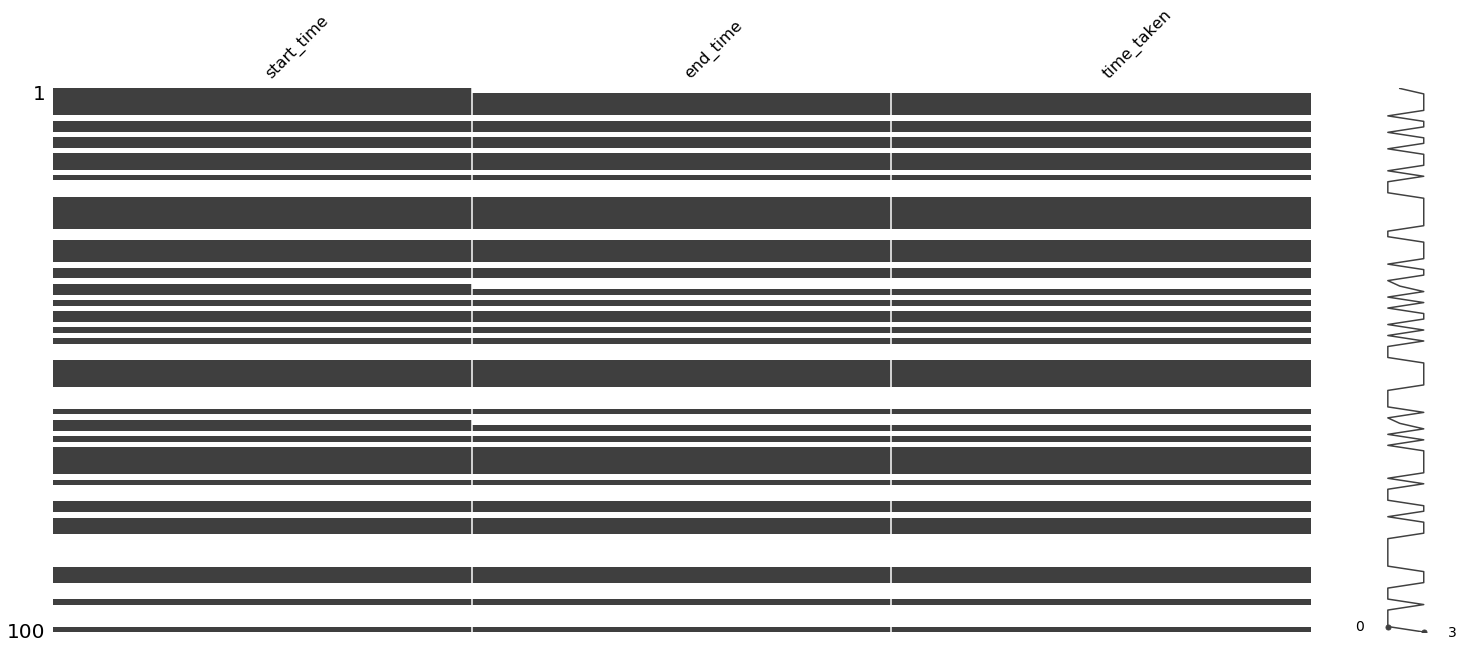

In [8]:
msno.matrix(data_table[["start_time", "end_time", "time_taken"]].head(100))

and with code:

In [9]:
data_table.end_time.isnull().equals(data_table.time_taken.isnull())

True

check if other columns have any NaN values. Empty list is good!

In [10]:
data_table.loc[data_table[["date","ordinal_date","activity","activity status","planned"]].isna().all(axis=1)]

,date,ordinal_date,dayofweek,start_time,end_time,time_taken,activity,activity status,planned


# Data completeness
Some stats for events with times

In [11]:
#Some counts
print("total entries", "\t",len(data_table))
print("entries with...")
print("start_time", "\t", len(data_table['start_time'].loc[data_table['start_time'].isna() == False]))
print("end_time", "\t", len(data_table['end_time'].loc[data_table['end_time'].isna() == False]))

total entries 	 1413
entries with...
start_time 	 816
end_time 	 795


# Counts and Frequencies by day of the week
With most of the data checking out of the way. Can start doing some basic frequency analysis!  
First some simple frequency counts:  
1. How many of each day is in the dataset?
2. How many days are in 2018 and in 2019?
3. Since I worked for all of 2018, how many days are represented in 2018 out of the total days in the year?

#### 1. How many of each day is in the dataset?
I can get this by abusing the pandas groupby method to get an index composed of each unique date with its dayofweek name. Then I can use Counter() to get frequencies.

In [62]:
freq_of_days = Counter(data_table.groupby(['date', 'dayofweek']).count().index.get_level_values(1))
pd.Series(freq_of_days)

Thursday     61
Friday       59
Monday       60
Tuesday      61
Wednesday    61
Sunday        2
dtype: int64

A sum of `freq_of_days` should equal the length of a list of unique dates in the dataset (which it does!)

In [51]:
np.sum(list(freq_of_days.values()))

304

In [56]:
len(data_table['date'].unique())

304

#### 1.1 How many days are in 2018 or in 2019?
I worked for the entirety of 2018 **(although this dataset starts on the 1st of March for now)**, barring a few weeks of Holidays (see below). I only worked until the last week of June in 2019 before my contract expired (science funding is fickle!). Note that the presence of the day in this dataset could be from a note or for a very small activity, or could be a sick day/holiday. The lack of any Saturdays is due to the strong defense of limits on my job description by those who came before me in the same role and with the same boss. I am fortunate that I could stick to a (mostly) 9 to 5 weekday schedule for my work.

In [66]:
#filter by year and then use groupby and Counter()
temp_df = data_table.loc[data_table['date'].map(lambda x: x.year == 2018)]
CountOfDaysIn2018 = Counter(temp_df.groupby(['date', 'dayofweek']).count().index.get_level_values(1))

#repeat for 2019
temp_df = data_table.loc[data_table['date'].map(lambda x: x.year == 2019)]
CountOfDaysIn2019 = Counter(temp_df.groupby(['date', 'dayofweek']).count().index.get_level_values(1))

In [74]:
print("Total days: %.0f" % np.sum(list(CountOfDaysIn2018.values())))
pd.Series(CountOfDaysIn2018)

Total days: 205


Thursday     42
Friday       40
Monday       40
Tuesday      41
Wednesday    41
Sunday        1
dtype: int64

In [75]:
print("Total days: %.0f" % np.sum(list(CountOfDaysIn2019.values())))
pd.Series(CountOfDaysIn2019)

Total days: 99


Monday       20
Tuesday      20
Wednesday    20
Thursday     19
Friday       19
Sunday        1
dtype: int64

#### 1.2 Visualisation of when I worked
It might be interesting to see the days I worked visualised as a horizontal bar graph.  
This is easy to implement as I can use `broken_barh` from matplotlib. Each day can be represented by a unit of 1 on the x axis and visualised with an arbitrary sized y unit. I can get all the unique ordinal dates which are already in the correct format and zip them with a list of 0.9's of the same length and feed it to broken_barh.  
**Graph discussion here**  
There is a pretty clear pattern of week/weekend throughout the graph. There are some bigger gaps marking three Holidays I took, the largest being a combined christmas break and holiday.

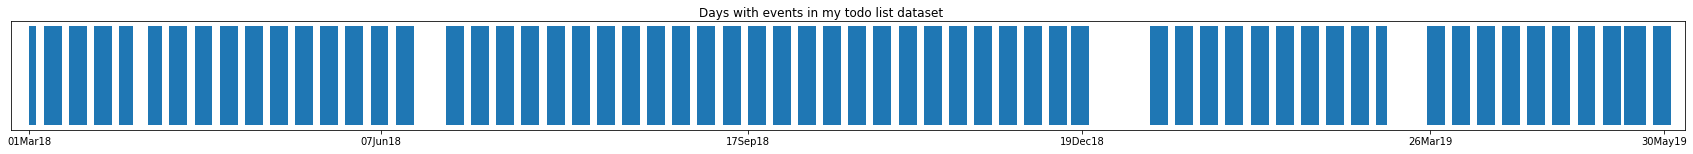

In [152]:
#process data to get what I need
ordinal_dates = data_table['ordinal_date'].unique()
length = len(ordinal_dates)
barh_input = list(zip(ordinal_dates,[1 for x in range(0,length)]))

#build figure
fig, ax = plt.subplots(1, figsize=(30,2))
ax.broken_barh(barh_input, yrange=(0,1))

#title
fig.suptitle("Days with events in my todo list dataset")

#fix x-axis whitespace
ax.set_xlim(-5,461)

#hide yticks
ax.set_yticks([])
#we can set the xtick labels to dates instead of raw numbers
#get labels, chosen so I can pull dates from the dataset
ax.set_xticks([0, 98, 200, 293, 390, 455])
#ax.set_xticklabels
ax.set_xticklabels(['01Mar18', '07Jun18','17Sep18','19Dec18','26Mar19','30May19'])

plt.show()

#### 2. How many events are in 2018 and in 2019?
This is a count of events rather than days.

In [14]:
print("# events in 2018:", len(data_table.loc[data_table['date'].map(lambda x: x.year == 2018)]))
print("# events in 2019:", len(data_table.loc[data_table['date'].map(lambda x: x.year == 2019)]))

# days in 2018: 966
# days in 2019: 447


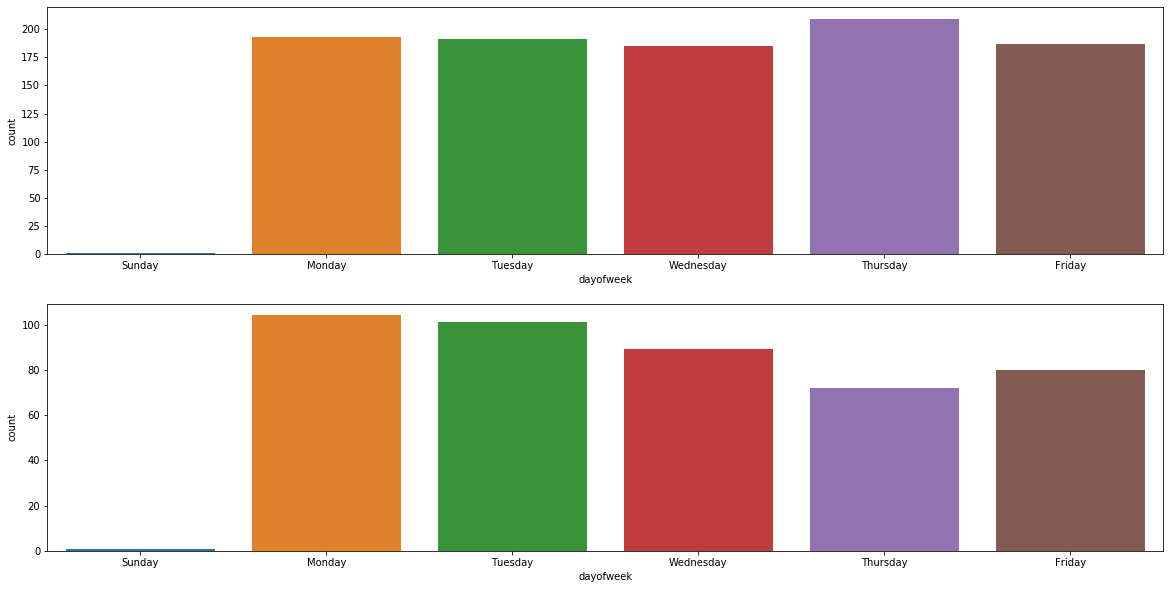

In [15]:
#
f, ax = plt.subplots(2, figsize=(20,10))
sns.countplot(ax=ax[0], x='dayofweek', data=data_table.loc[data_table['date'].map(lambda x: x.year == 2018)],
              order=["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday"])

sns.countplot(ax=ax[1], x='dayofweek', data=data_table.loc[data_table['date'].map(lambda x: x.year == 2019)],
              order=["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday"])
plt.show()

### Count of events that happened on each day
This is a raw count of *events* that occurred on each day.

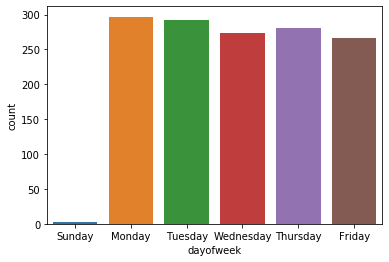

In [16]:
#count of all events by day of week
f, ax = plt.subplots()
sns.countplot(ax=ax, x='dayofweek', data=data_table, order=["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday"])
plt.show()

### Distribution of count of events per day
Lets take a look at distribution and outliers with some box and whiskers plots

In [17]:
#Counter() gives a frequency table of keys in a given dataframe row
count_per_day = pd.Series(Counter(data_table['ordinal_date'])).sort_values()
count_per_day.describe()

count    304.000000
mean       4.648026
std        2.015893
min        1.000000
25%        3.000000
50%        5.000000
75%        6.000000
max       12.000000
dtype: float64

Graphing the distribution of activity frequency per day shows a roughly skewed normal distribution with a few high outliers and more days with 1 activity than with 2 activities.

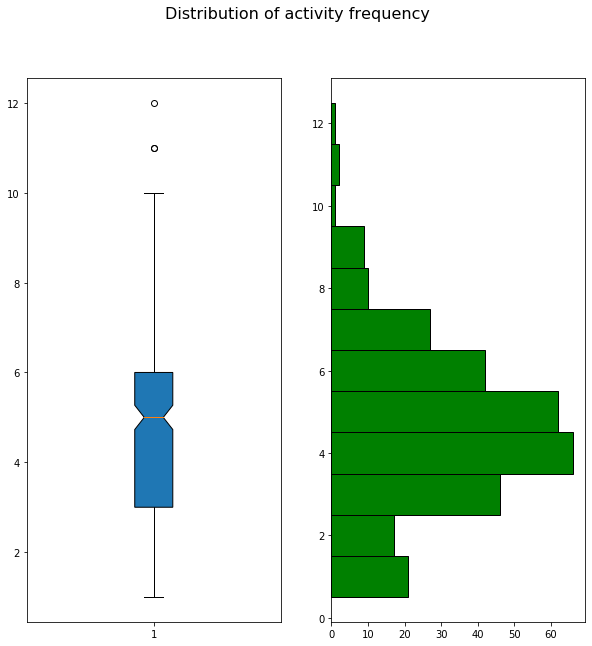

In [18]:
#calling Counter(count_per_day) gives a frequency table of activities per ordinal_date

fig, ax = plt.subplots(1,2, figsize=(10,10))

ax[0].boxplot(count_per_day, patch_artist=True, notch=True)

#using ax.barh makes it easier to give individual bars for each integer value rather than ax.hist
ax[1].barh(y=[x for x in range(1,13)],width=Counter(count_per_day).values(), 
           color='green', height=1, linewidth=1, edgecolor='black')

fig.suptitle('Distribution of activity frequency', fontsize=16)

plt.show()

### Distributions of activity frequency per day filtered by activity status
I made this before realising it was pretty worthless so it stays here

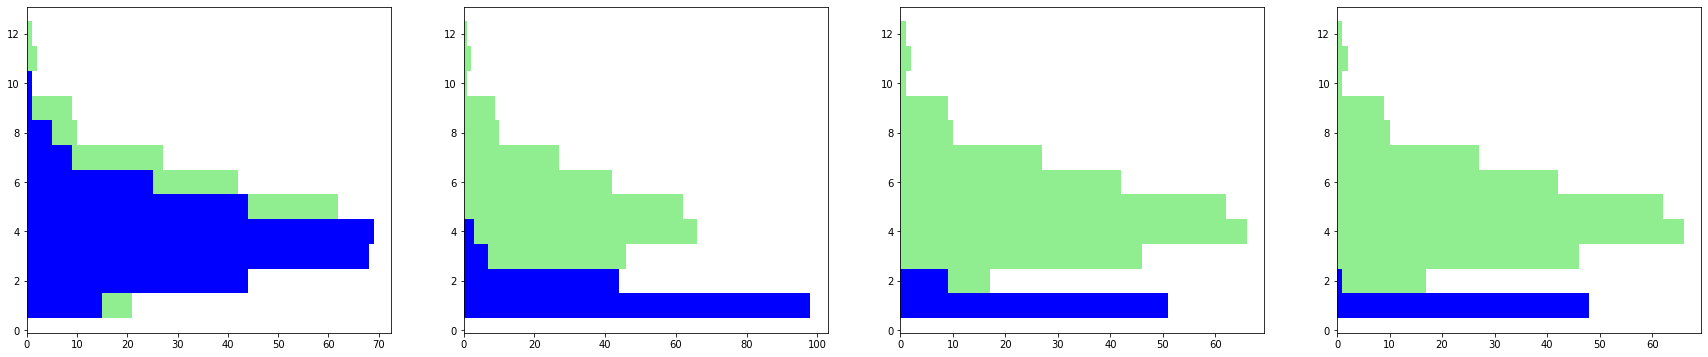

In [19]:
#build frequency tables filtered by activity status
count_per_day_done = pd.Series(Counter(data_table.loc[data_table['activity status']=='done']['ordinal_date'])).sort_values()
count_per_day_ntdone = pd.Series(Counter(data_table.loc[data_table['activity status']=='not done']['ordinal_date'])).sort_values()
count_per_day_part = pd.Series(Counter(data_table.loc[data_table['activity status']=='partly done']['ordinal_date'])).sort_values()
count_per_day_note = pd.Series(Counter(data_table.loc[data_table['activity status']=='note']['ordinal_date'])).sort_values()

#build figure with overlay of full dataset behind each filtered distribution
fig, ax = plt.subplots(1,4, figsize=(30,6))

#places background histogram in all 4 subplots
for i in range(0,4):
    ax[i].barh(y=list(Counter(count_per_day).keys()),width=Counter(count_per_day).values(), 
           color='lightgreen', height=1)
    
#overlay with filtered plots
filtered_sets = [count_per_day_done, count_per_day_ntdone, count_per_day_part, count_per_day_note]
#for i in range(0,4):
#    ax[i].barh(y=[x for x in range(1,13)],width=Counter(filtered_sets[i]).values(), 
#           color='blue', height=1)
for i in range(0,4):
    temp_dataset = Counter(filtered_sets[i])
    ax[i].barh(y=list(temp_dataset.keys()),width=temp_dataset.values(), 
               color='blue', height=1)

## Frequency of activities for each day of the week
Interested in activities for each day of the week. I am also interested in answering whether the ratio of planned and unplanned activities changes between each day

In [20]:
#the use of 'ordinal_date' column here is arbitrary as I just need one column of counts and not several
grouped = data_table.groupby(['date','dayofweek'])['ordinal_date'].count().groupby('dayofweek')
dayofweek_freq = pd.DataFrame(index=['mean','std'], data=[grouped.mean(),grouped.std()]).T
#reindex to get days in a sensible order and drop Sunday since it is such a small sample (n=2)
days_of_week = ["Monday","Tuesday","Wednesday","Thursday","Friday"]
dayofweek_freq= dayofweek_freq.reindex(days_of_week)
dayofweek_freq

,mean,std
dayofweek,,
Monday,4.950000,2.324702
Tuesday,4.786885,2.034001
Wednesday,4.491803,1.699244
Thursday,4.606557,2.059763
Friday,4.525424,1.860255


A bar graph quickly shows that there is no notable trend here and the variation in the data is far too large to find any small changes anyway

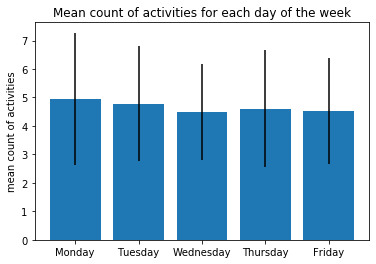

In [21]:
plt.bar(x=days_of_week, height=dayofweek_freq['mean'].values, yerr=dayofweek_freq['std'].values)
plt.title('Mean count of activities for each day of the week')
plt.ylabel("mean count of activities")
plt.show()

How does the mean change when looking at activity status and planned/unplanned events?

In [22]:
planned_v_unplanned = data_table.groupby(["planned","date","dayofweek"]).activity.count().groupby(['planned','dayofweek']).aggregate([np.mean,np.std])
#reindex days in sensible order
planned_v_unplanned = planned_v_unplanned.reindex(days_of_week,level=1)
planned_v_unplanned

mean       std
planned dayofweek                    
False   Monday     2.064516  1.436094
        Tuesday    2.666667  1.300406
        Wednesday  2.395833  1.364280
        Thursday   2.977778  1.712108
        Friday     3.400000  1.586878
True    Monday     3.883333  1.795396
        Tuesday    2.950820  1.309278
        Wednesday  2.694915  1.476882
        Thursday   2.773585  1.588922
        Friday     2.192308  1.428539

### Graph of mean activities per day split by whether they were planned or unplanned
Note the trend of decreasing numbers of planned activities as the week progressed and increasing unplanned activities  
This can be explained by my habit of planning my week late on fridays or early on mondays. I would often not have a full week of work and would gain new (unplanned) activities through the week.

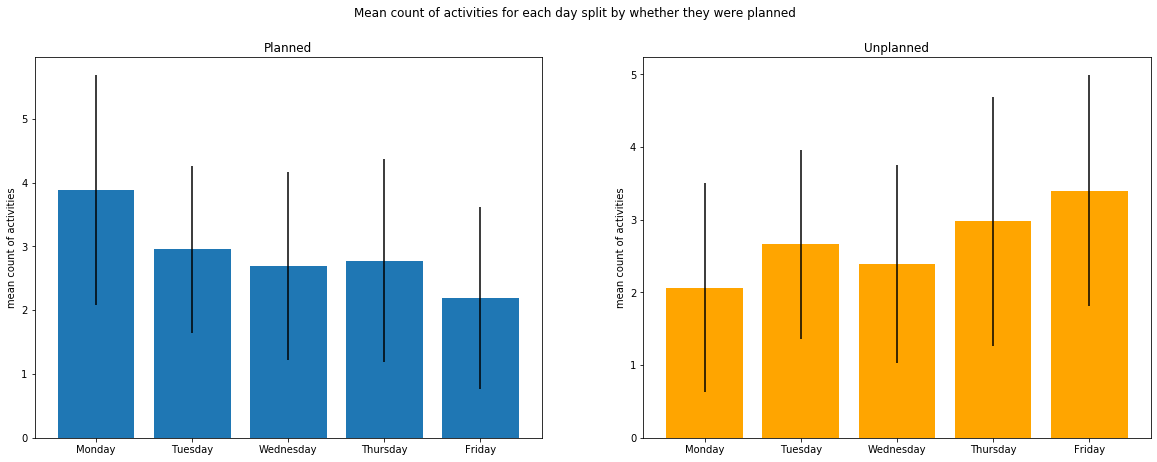

In [23]:
#get values in a format that matplotlib accepts easily
x_false = planned_v_unplanned.loc[False]['mean'].values
x_true = planned_v_unplanned.loc[True]['mean'].values

x_false_std = planned_v_unplanned.loc[False]['std'].values
x_true_std = planned_v_unplanned.loc[True]['std'].values

#build figure
fig, axs = plt.subplots(1,2, figsize=(20, 7))
axs[0].bar(x=days_of_week, height=x_true, yerr=x_true_std)
axs[1].bar(x=days_of_week, height=x_false, yerr=x_false_std, color='orange')

#labels
axs[0].set_title("Planned")
axs[0].set_ylabel('mean count of activities')

axs[1].set_title("Unplanned")
axs[1].set_ylabel('mean count of activities')

fig.suptitle("Mean count of activities for each day split by whether they were planned")
plt.show()

# Activity Status
Freq of done/not done  
done/not done by day of the week  
done/not done by each month I worked

What options exist in 'activity status'?  
done and not done make sense. Partly done was derived from a set of rules established in ipython workbook that generated the dataset.  
'note' entries were determined by presence of "sick" or "\["

In [24]:
Counter(data_table['activity status'])

Counter({'done': 1075, 'not done': 219, 'partly done': 69, 'note': 50})

### Frequencies of activity by activity status and day of the week
The below groupby shows that there were many more 'done' activities than not done. There is no trend through the week for 'done' or 'not done'. For 'partly done' there is a lot more activities on monday and thursday than other days, but I have no explanation for why this might be the case. Maybe a quirk of how I think about planning?

In [25]:
#groupby and get frequency. Use reindex method to order things sensibly and drop Sunday
activity_status_by_weekday = data_table.groupby(['activity status', 'dayofweek']).date.count().reindex(days_of_week,level=1)
activity_status_by_weekday

activity status  dayofweek
done             Monday       220
                 Tuesday      224
                 Wednesday    214
                 Thursday     210
                 Friday       206
not done         Monday        43
                 Tuesday       47
                 Wednesday     40
                 Thursday      47
                 Friday        42
note             Monday        13
                 Tuesday        9
                 Wednesday     10
                 Thursday       8
                 Friday        10
partly done      Monday        21
                 Tuesday       12
                 Wednesday     10
                 Thursday      16
                 Friday         9
Name: date, dtype: int64

Here are some quick graphs for this

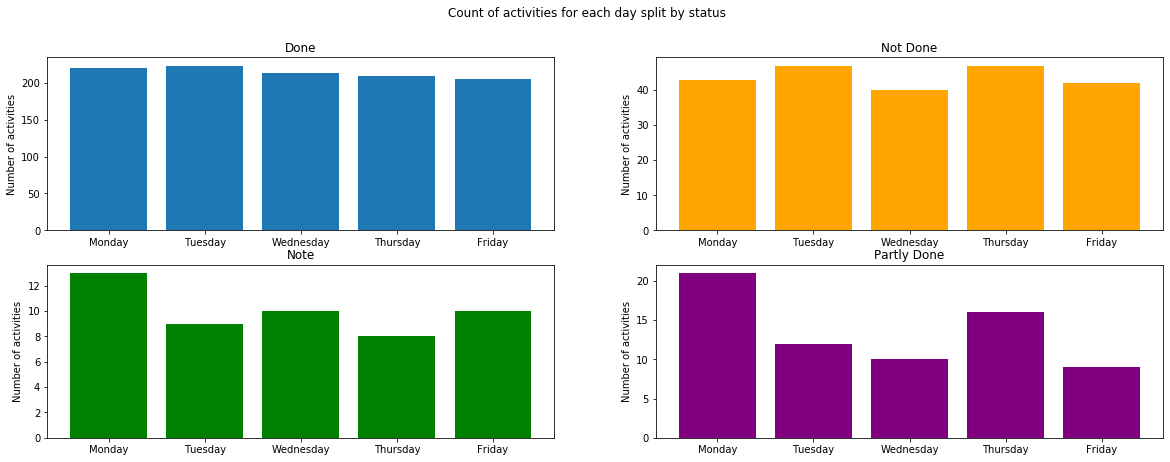

In [26]:
#get values in a format that matplotlib accepts easily
x_done = activity_status_by_weekday['done']
x_notdone = activity_status_by_weekday['not done']
x_note = activity_status_by_weekday['note']
x_partly = activity_status_by_weekday['partly done']

#build figure
fig, axs = plt.subplots(2,2, figsize=(20, 7))

axs[0,0].bar(x=days_of_week, height=x_done)
axs[0,0].set_title("Done")
axs[0,0].set_ylabel('Number of activities')

axs[0,1].bar(x=days_of_week, height=x_notdone, color='orange')
axs[0,1].set_title("Not Done")
axs[0,1].set_ylabel('Number of activities')

axs[1,0].bar(x=days_of_week, height=x_note, color='green')
axs[1,0].set_title("Note")
axs[1,0].set_ylabel('Number of activities')

axs[1,1].bar(x=days_of_week, height=x_partly, color='purple')
axs[1,1].set_title("Partly Done")
axs[1,1].set_ylabel('Number of activities')

fig.suptitle("Count of activities for each day split by status")
plt.show()

These would be better compared on a single bar graph

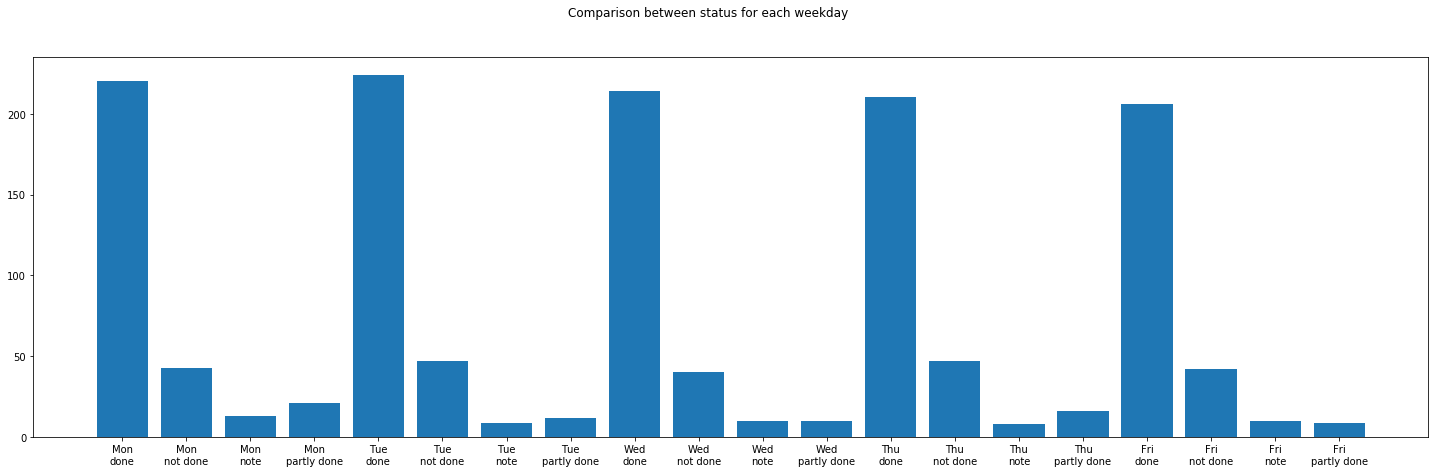

In [27]:
#put all values into a single labelled dict
results_dict = {}
for day in days_of_week:
    for status in ['done', 'not done', 'note', 'partly done']:
        combined_string_key = day[0:3] + '\n' + status
        results_dict[combined_string_key] = activity_status_by_weekday[status][day]

x = list(results_dict.keys())
height = list(results_dict.values())
        
#generate bar chart
fig, ax= plt.subplots(1,figsize = (25,7))

ax.bar(x, height)

fig.suptitle("Comparison between status for each weekday")

#plt.xticks(rotation=90)

plt.show()

In [28]:
data_table

,date,ordinal_date,dayofweek,start_time,end_time,time_taken,activity,activity status,planned
0,2018-03-01,0,Thursday,09:00:00,NaN,NaN,9: Take histo down to Nick in the store on lvl 1,done,True
1,2018-03-01,0,Thursday,10:30:00,13:30:00,180.0,10:30-1:30: Animal facilities induction,done,True
2,2018-03-01,0,Thursday,14:00:00,15:00:00,60.0,2-3: Microbiome meeting,done,True
3,2018-03-01,0,Thursday,14:30:00,17:00:00,150.0,2:30-5: KB22 Collagen Analysis,done,True
4,2018-03-02,1,Friday,09:00:00,16:00:00,420.0,9-4: BALF processing for endpoint (Alex),done,True
5,2018-03-02,1,Friday,NaN,NaN,NaN,Everything else postponed until next week.,done,True
6,2018-03-02,1,Friday,09:30:00,13:00:00,210.0,"9:30-1: KB22 RNA extraction, last samples!",not done,True
7,2018-03-02,1,Friday,09:00:00,17:00:00,480.0,9-5: PISA (Brit/Alex) Cancelled,not done,True
8,2018-03-02,1,Friday,NaN,NaN,NaN,Intermittent: Collagen analysis. MLI images fo...,not done,True
9,2018-03-02,1,Friday,09:00:00,13:00:00,240.0,9-1: RT on 50 samples (Kurtis) Postponed becau...,not done,True
